In [45]:
import numpy as np
from nltk.corpus import stopwords
from torch.distributed.pipelining import pipeline

In [2]:
import pandas as pd
import nltk
import seaborn as sns

In [3]:
df = pd.read_csv("../../datasets/Amazon_Reviews_Sentiment_Analysis.csv")

In [4]:
df[:20]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
2,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
3,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
4,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
5,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
6,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
7,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
8,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
9,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


In [5]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [6]:
df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [7]:
import matplotlib.pyplot as plt

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [8]:
plt.style.use("ggplot")

In [9]:
%%markdown 
## EDA

## EDA


In [12]:
df["Score"].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import (
    pipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
import datasets
from tqdm.auto import tqdm

sia = SentimentIntensityAnalyzer()
# from transformers import pipeline
# from transformers.pipelines.pt_utils import KeyDataset

In [27]:
# Catch up with the world fast
analyzer = pipeline("sentiment-analysis")  # transformers pipeline, no idea what this is

oracle = pipeline(
    "question-answering",
    model="distilbert/distilbert-base-cased-distilled-squad",
    tokenizer="google-bert/bert-base-cased",
)  # Yeah no idea
model = AutoModelForTokenClassification.from_pretrained(
    "dbmdz/bert-large-cased-finetuned-conll03-english"
)  # No idea
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")  # No idea
recognizer = pipeline("ner", model=model, tokenizer=tokenizer, device=1)  # Okay no idea

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mo

In [28]:
print(sia.polarity_scores("I am excited to do this project again"))

{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.34}


In [29]:
print(df["Score"].value_counts())
print(df["Score"].value_counts().sort_index())

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


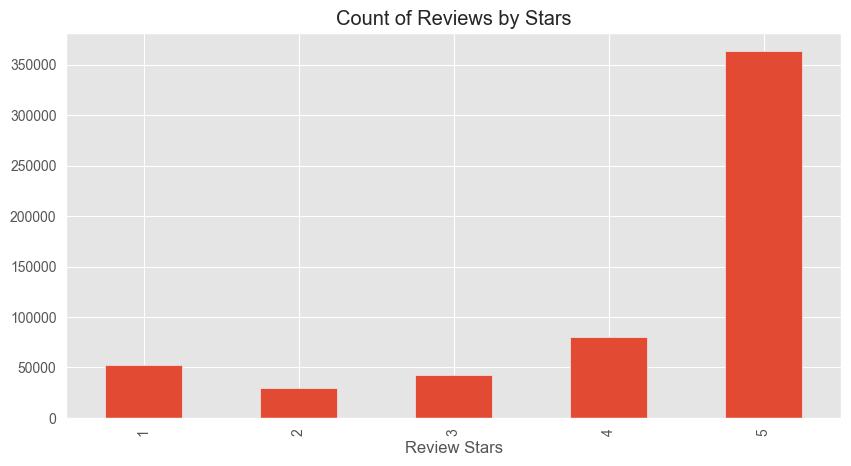

In [30]:
ax = (
    df["Score"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", title="Count of Reviews by Stars", figsize=(10, 5))
)
ax.set_xlabel("Review Stars")
plt.show()

In [53]:
text = df["Text"][2]
stopwords = ""
with open("../../../data/stopwords.txt", "r") as f:
    stopwords = f.read()

# print(stopwords)
text = " ".join([f for f in text.split(" ") if f not in stopwords])

In [54]:
print(text)
sia.polarity_scores(text)

This saltwater taffy great flavors soft chewy. Each candy individually wrapped well. None candies stuck together, happen expensive version, Fralinger's. Would highly recommend candy! I served beach-themed party everyone loved it!


{'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.951}

In [34]:
sia.polarity_scores(
    "I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most."
)

{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [35]:
# df["Score"].sort_values(ascending=False)

In [55]:
tokens = nltk.word_tokenize(text)

In [56]:
tokens

['This',
 'saltwater',
 'taffy',
 'great',
 'flavors',
 'soft',
 'chewy',
 '.',
 'Each',
 'candy',
 'individually',
 'wrapped',
 'well',
 '.',
 'None',
 'candies',
 'stuck',
 'together',
 ',',
 'happen',
 'expensive',
 'version',
 ',',
 'Fralinger',
 "'s",
 '.',
 'Would',
 'highly',
 'recommend',
 'candy',
 '!',
 'I',
 'served',
 'beach-themed',
 'party',
 'everyone',
 'loved',
 'it',
 '!']

In [42]:
tokens[:10]

['This',
 'saltwater',
 'taffy',
 'had',
 'great',
 'flavors',
 'and',
 'was',
 'very',
 'soft']

In [57]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('This', 'DT'), ('saltwater', 'NN'), ('taffy', 'VBZ'), ('great', 'JJ'), ('flavors', 'NNS'), ('soft', 'JJ'), ('chewy', 'NNS'), ('.', '.'), ('Each', 'DT'), ('candy', 'NN'), ('individually', 'RB'), ('wrapped', 'VBD'), ('well', 'RB'), ('.', '.'), ('None', 'NN'), ('candies', 'NNS'), ('stuck', 'VBP'), ('together', 'RB'), (',', ','), ('happen', 'VB'), ('expensive', 'JJ'), ('version', 'NN'), (',', ','), ('Fralinger', 'NNP'), ("'s", 'POS'), ('.', '.'), ('Would', 'MD'), ('highly', 'RB'), ('recommend', 'VB'), ('candy', 'NN'), ('!', '.'), ('I', 'PRP'), ('served', 'VBD'), ('beach-themed', 'JJ'), ('party', 'NN'), ('everyone', 'NN'), ('loved', 'VBD'), ('it', 'PRP'), ('!', '.')]


In [58]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  saltwater/NN
  taffy/VBZ
  great/JJ
  flavors/NNS
  soft/JJ
  chewy/NNS
  ./.
  Each/DT
  candy/NN
  individually/RB
  wrapped/VBD
  well/RB
  ./.
  None/NN
  candies/NNS
  stuck/VBP
  together/RB
  ,/,
  happen/VB
  expensive/JJ
  version/NN
  ,/,
  (PERSON Fralinger/NNP)
  's/POS
  ./.
  Would/MD
  highly/RB
  recommend/VB
  candy/NN
  !/.
  I/PRP
  served/VBD
  beach-themed/JJ
  party/NN
  everyone/NN
  loved/VBD
  it/PRP
  !/.)


In [59]:
from tqdm.notebook import tqdm

print(len(df))

568454


In [60]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [64]:
x = pd.DataFrame(res).T
print(x.head())
x.describe()

     neg    neu    pos  compound
1  0.000  0.695  0.305    0.9441
5  0.000  0.552  0.448    0.9468
7  0.034  0.693  0.273    0.9346
8  0.000  0.520  0.480    0.9487
9  0.000  0.851  0.149    0.6369


,neg,neu,pos,compound
count,568454.000000,568454.000000,568454.000000,568454.000000
mean,0.042283,0.765371,0.192336,0.647317
std,0.051978,0.101262,0.106877,0.466243
min,0.000000,0.000000,0.000000,-0.999400
25%,0.000000,0.704000,0.116000,0.576400
50%,0.028000,0.775000,0.179000,0.854600
75%,0.066000,0.836000,0.257000,0.942100
max,0.939000,1.000000,0.964000,0.999900


In [65]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")
print(vaders[:0])

Empty DataFrame
Columns: [Id, neg, neu, pos, compound, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []


# Using Vaders to Predict

In [66]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
2,7,0.034,0.693,0.273,0.9346,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
3,8,0.000,0.520,0.480,0.9487,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
4,9,0.000,0.851,0.149,0.6369,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...


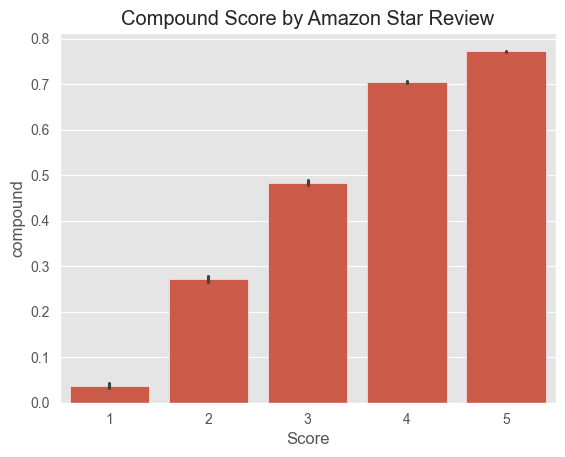

In [67]:
ax = sns.barplot(data=vaders, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

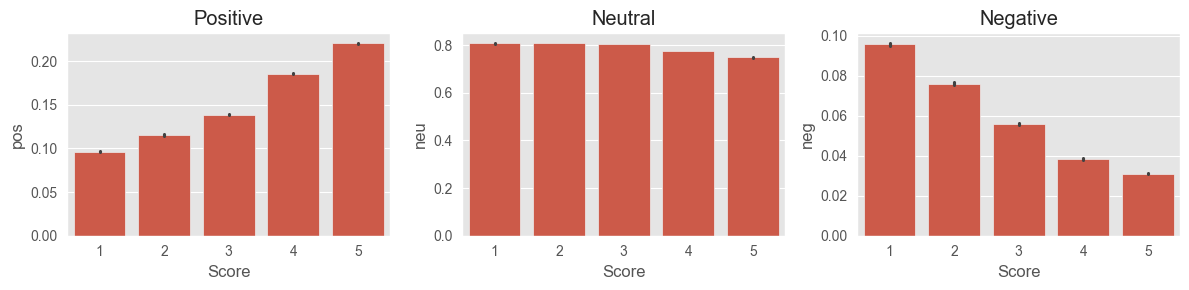

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x="Score", y="pos", ax=axs[0])
sns.barplot(data=vaders, x="Score", y="neu", ax=axs[1])
sns.barplot(data=vaders, x="Score", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout()
plt.show()

# Finally Using Transformers Sentiment Analysis

In [70]:
import os


# os.environ["TOKENIZERS_PARALLELISM"] = "True"
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# AutoTokenizer.from_pretrained
Can build our own model and use in AutoTokenizer... Target 31st January..

In [73]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment"
)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [75]:
print(text)
encoded_text_check = tokenizer(df["Text"][3], return_tensors="pt")
print(encoded_text_check)

I just bought this soup today at my local grocer, brought it back to work with me, heated it up and almost spit out my first bite.  The taste is so sweet, and it's not just the aftertaste as a previous commenter said.  This soup is horrible!  It tastes nothing like true Cajun red beans and rice.  I tried complaining via the Healthy Choice website today, only to have their servers fail twice before it wiped my complaint.<br /><br />DO NOT BUY THIS SOUP.<br /><br />I have never been so dissatisfied with food before I ate this soup.  I'm the type that will say, "eh, it doesn't taste good, but I bought it, so I'll eat it," but miraculously I ate three spoonfuls before I gave up and tossed the rest in the trash.  Tomato puree is one of the first three ingredients (high sugar), followed closely by evaporated cane juice?  Who puts evaporated cane juice in red beans and rice?  Healthy Choice, that's who!  Hey, Healthy Choice, maybe if you didn't add the evaporated cane juice this soup may very

In [81]:
encoded_text = tokenizer(text, return_tensors="pt")
output = model(**encoded_text)


def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2],
    }
    return scores_dict

In [82]:
from multiprocessing import Process, Pool
from threading import Thread


# BottleNeck:
def transformers():
    res = {}
    for i, row in tqdm(df.iterrows(), total=5000):
        try:
            text = row["Text"]
            myid = row["Id"]
            vader_result = sia.polarity_scores(text)
            vader_result_rename = {}
            for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
            roberta_result = polarity_scores_roberta(text)
            both = {**vader_result_rename, **roberta_result}
            res[myid] = both
        except RuntimeError:
            print(f"Broke for id {myid}")


transformers()

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1498
Broke for id 1575
Broke for id 2169
Broke for id 2492
Broke for id 2610
Broke for id 2928
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 5040
Broke for id 5182
Broke for id 5709
Broke for id 5998
Broke for id 6007
Broke for id 6234
Broke for id 6558
Broke for id 6850
Broke for id 7077
Broke for id 7088
Broke for id 7201
Broke for id 7604
Broke for id 7608
Broke for id 7671
Broke for id 7701
Broke for id 7907
Broke for id 8131
Broke for id 8266
Broke for id 8757
Broke for id 8935
Broke for id 9881
Broke for id 9910
Broke for id 9923
Broke for id 10031
Broke for id 10550
Broke for id 10837
Broke for id 10861
Broke for id 10862
Broke for id 10863
Broke for id 10864
Broke for id 10885
Broke for id 10946
Broke for id 10969
Broke for id 11238
Broke for id 11239
Broke for id 11245
Broke for id 11302


IndexError: index out of range in self

In [41]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={"index": "Id"})
results_df = results_df.merge(df, how="left")

In [42]:
results_df.to_csv("Output.csv")

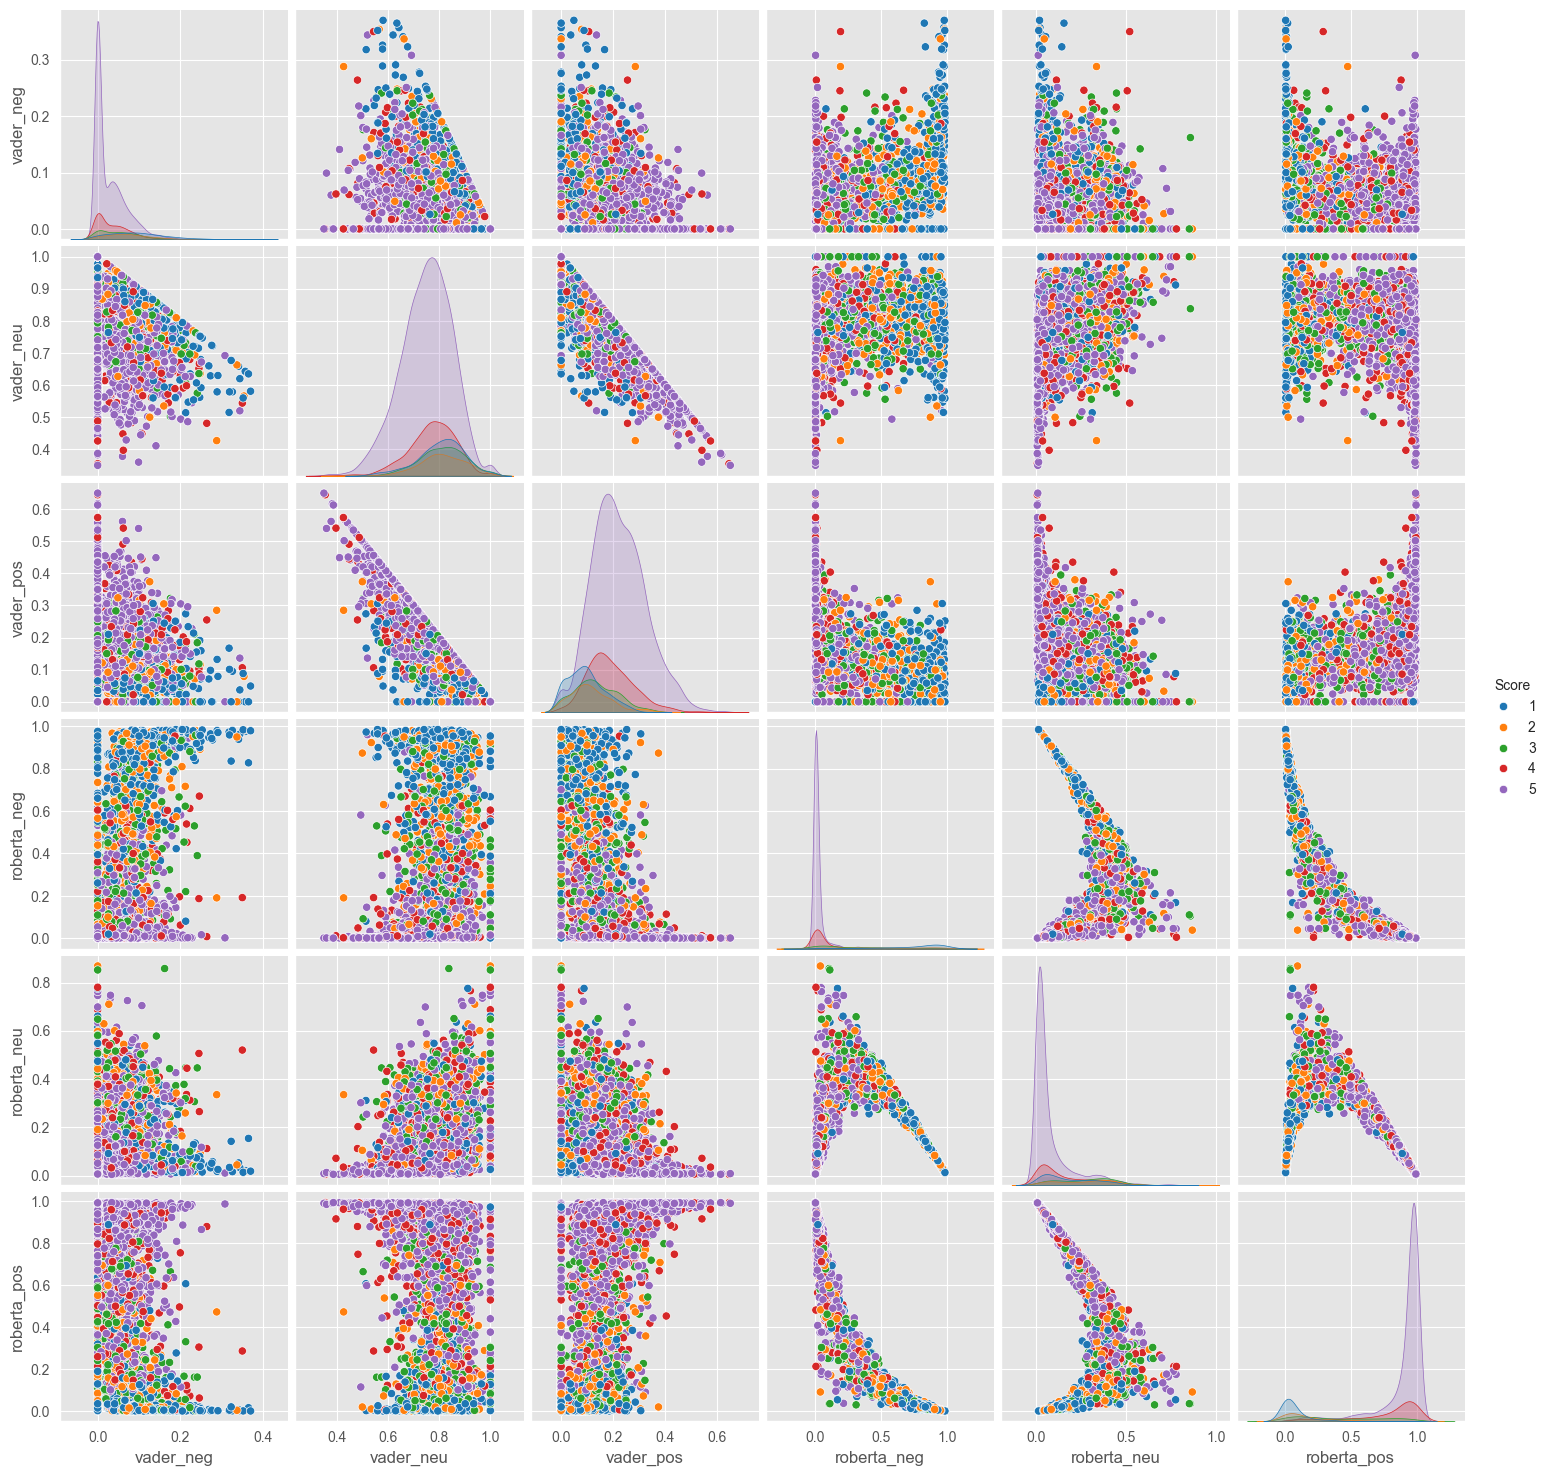

In [43]:
sns.pairplot(
    data=results_df,
    vars=[
        "vader_neg",
        "vader_neu",
        "vader_pos",
        "roberta_neg",
        "roberta_neu",
        "roberta_pos",
    ],
    hue="Score",
    palette="tab10",
)
plt.show()

In [44]:
plt.show()

In [45]:
reviews = results_df.to_csv("../../datasets/Reviews.csv")

In [46]:
results_df.query("Score == 1").sort_values("roberta_pos", ascending=False)[
    "Text"
].values[2]

"Second ingredient is SUGAR! Need I say more? Make your own bisquit mix, it's super easy!"

In [40]:
!pip3 install tf-keras
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00a 0:00:01


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [41]:
sent_pipeline("I love sentiment analysis!")

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [42]:
sent_pipeline("I am aroused")

[{'label': 'POSITIVE', 'score': 0.9974574446678162}]

In [43]:
sent_pipeline("boo hoo")

[{'label': 'NEGATIVE', 'score': 0.9349934458732605}]

In [54]:
?reviews

In [56]:
output = pd.read_csv("Output.csv")

In [57]:
output.head()

,Unnamed: 0,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [59]:
output.sort_values(key="Scores", ascending=False)

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [61]:
# Run for Roberta Model
encoded_text = tokenizer(text, return_tensors="pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    "roberta_neg": scores[0],
    "roberta_neu": scores[1],
    "roberta_pos": scores[2],
}
print(scores_dict)

{'roberta_neg': 0.0024397606, 'roberta_neu': 0.011327226, 'roberta_pos': 0.986233}


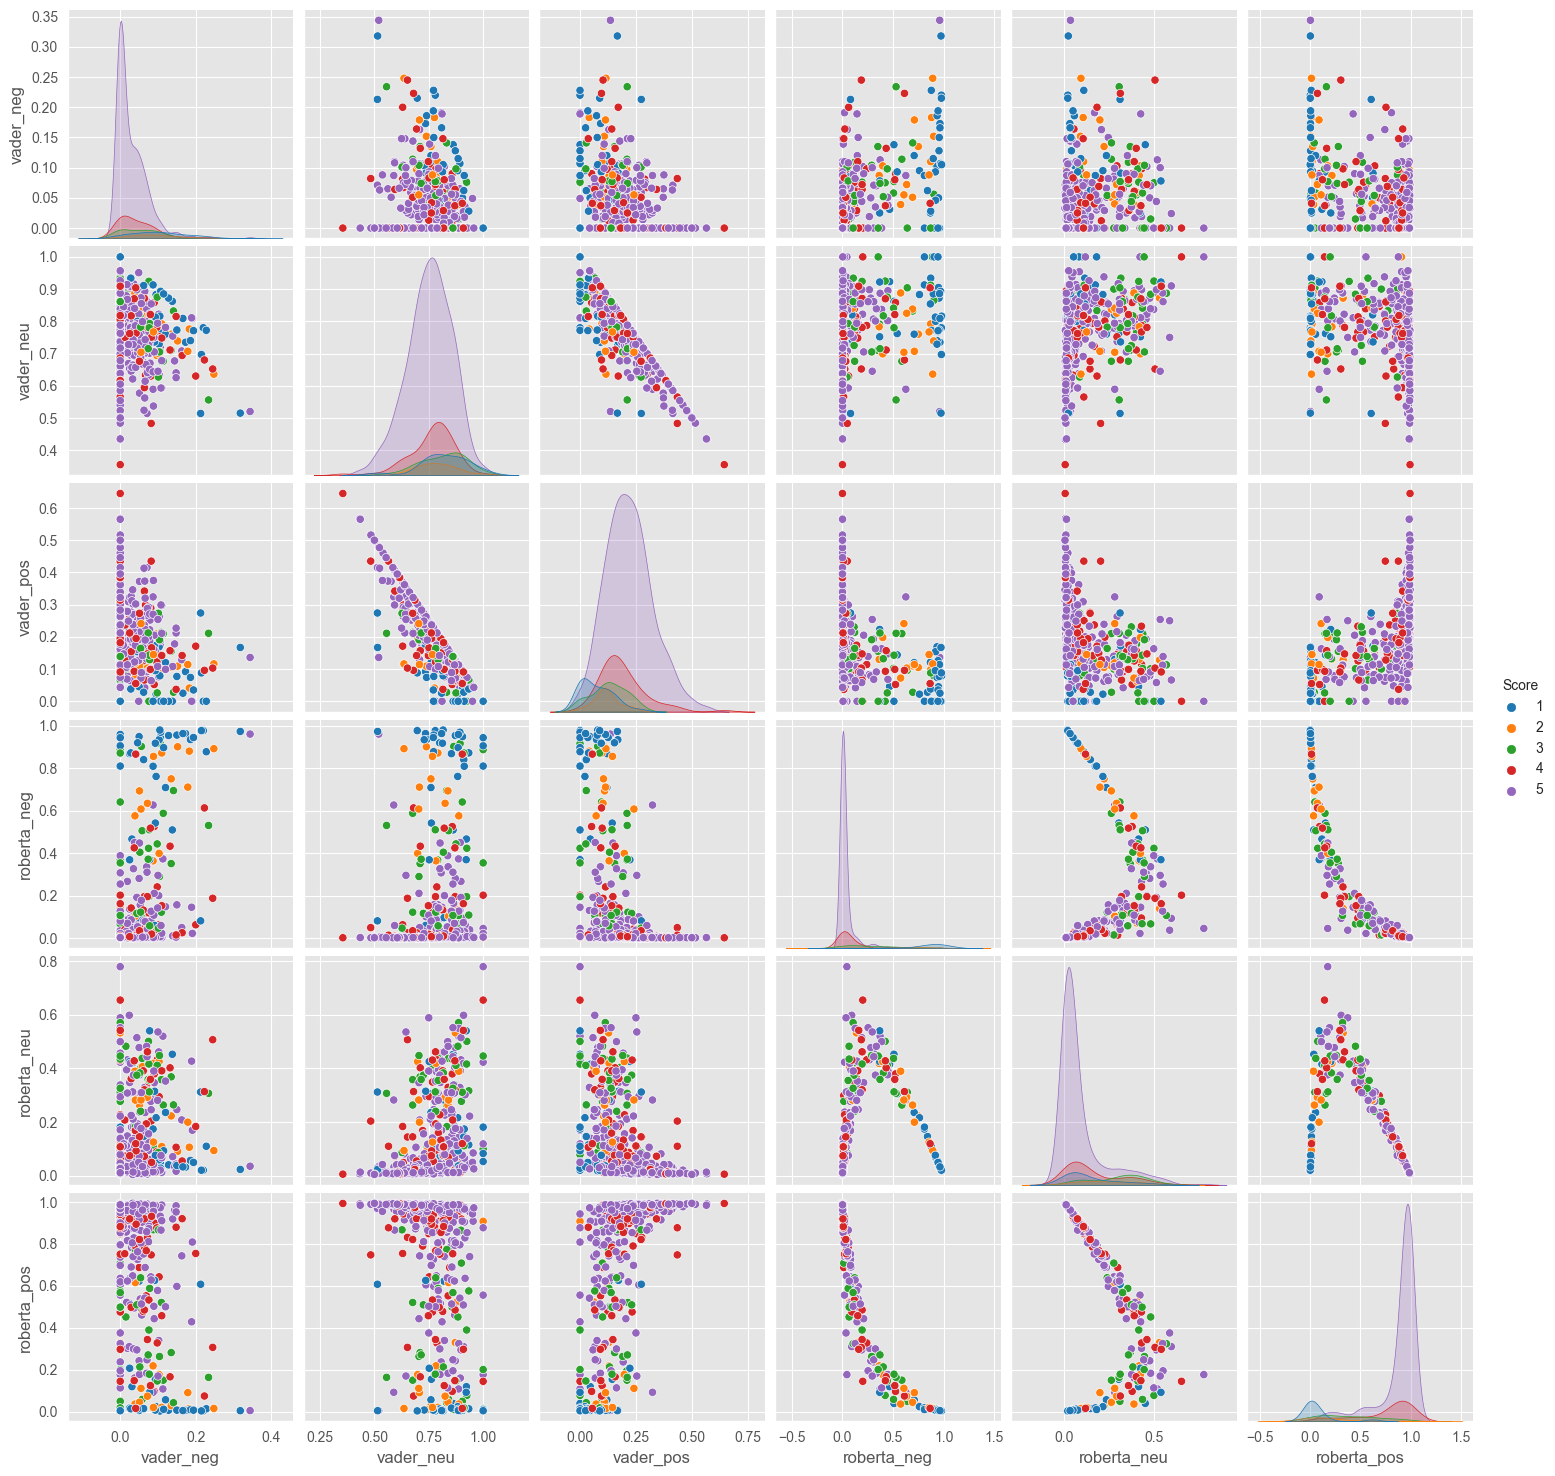

In [65]:
sns.pairplot(
    data=results_df,
    vars=[
        "vader_neg",
        "vader_neu",
        "vader_pos",
        "roberta_neg",
        "roberta_neu",
        "roberta_pos",
    ],
    hue="Score",
    palette="tab10",
)
plt.show()